## HW3
Name: Pei Tian, UNI: pt2632

In [1]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

import warnings
warnings.filterwarnings('ignore')

### Problem 1

#### 1a

In [2]:
data = pd.read_table('data/HW3-1.txt', header=0, index_col=0, delim_whitespace=True)
data.head()

,Sales,Profit,Assets
Company,,,
Citi,108.28,17.05,1484.10
GE,152.36,16.59,750.33
AIG,95.04,10.91,766.42
BoA,65.45,14.14,1110.46
HSBC,62.97,9.52,1031.29


In [3]:
# mean vector
data.mean()

Sales     155.603
Profit     14.704
Assets    710.911
dtype: float64

In [4]:
# covariance matrix
data.cov()

,Sales,Profit,Assets
Sales,7476.453246,303.618620,-35575.959570
Profit,303.618620,26.190316,-1053.827393
Assets,-35575.959570,-1053.827393,237054.269832


#### 1b

In [5]:
# 1b
X1 = data[["Sales", "Profit"]].to_numpy()
def generalized_dist(X):
    cov = np.cov(X, rowvar=False)
    d_squared = (X - X.mean(axis=0)) @ np.linalg.inv(cov) @ (X - X.mean(axis=0)).T
    return d_squared.diagonal()

d_squared = generalized_dist(X1)

In [6]:
crit = st.chi2.ppf(0.5, 2)
count = 0
for dist_sqaured in d_squared:
    if dist_sqaured <= crit:
        count += 1
print(f"{count/len(d_squared)*100:.0f}% of the data is within the 50% confidence ellipse")

40% of the data is within the 50% confidence ellipse


#### 1c

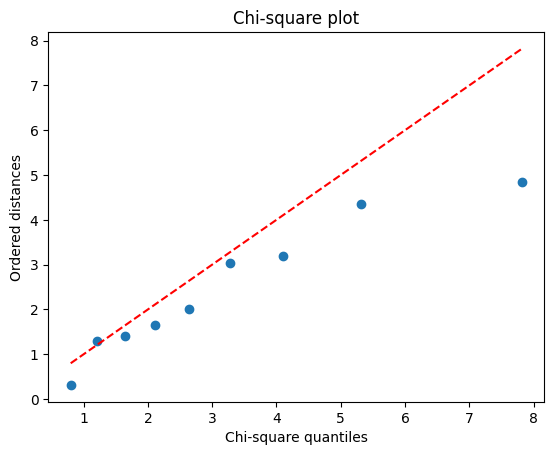

In [7]:
# 1c: chi-square plot
p = 3
n = data.shape[0]
X2 = data[["Sales", "Profit", "Assets"]].to_numpy()
d_squared2 = generalized_dist(X2)
prob = (np.arange(1, n+1) + 1 - 0.5) / n
chi_quantiles = st.chi2.ppf(prob, p)
plt.scatter(chi_quantiles, np.sort(d_squared2))
plt.plot(chi_quantiles, chi_quantiles, color='red', linestyle='--')
plt.title("Chi-square plot")
plt.xlabel("Chi-square quantiles")
plt.ylabel("Ordered distances")
plt.show()

**Conclusion:** The multivariate normality holds approximately given the chi-squared plot roughly aligns with $45^\degree$ line

### Problem 2

#### 2a
The training SSE of 2 models should be similar. 

**Reason:** 

Since the true relationship between $X$ and $Y$ is linear, the best possible fit would come from the linear model:

$$
Y = \beta_0 + \beta_1 X + \epsilon
$$

The cubic model:
$$
Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \beta_3 X^3 + \epsilon
$$

includes unnecessary terms ($X^2$ and $X^3$). However, when we fit this model, the estimated coefficients should be close to zero, because there is no quadratic or cubic effect in the true data-generating process.

Since the cubic model reduces to approximately the linear model (with extra terms that are close to zero), both models should have very similar training SSE.
Any small difference in training SSE would come from the cubic model slightly overfitting noise, but this difference should be minimal.

#### 2b
The testing SSE of 2 models should be similar.

**Reason:**
Since the true relationship is linear, the best-fitting model for unseen data should also be the linear model.

The cubic model has unnecessary terms that were fitted to random variations (noise) in the training data.
When applied to the test data, these extra terms do not contribute useful information and might slightly worsen the predictions.
However, since the coefficients of $X^2$ and $X^3$ should be close to zero, the cubic model is still approximately a linear model.
As a result, the test SSE should be similar between the two models, though the cubic model might perform slightly worse if it overfits noise.

#### 2c - Simulation

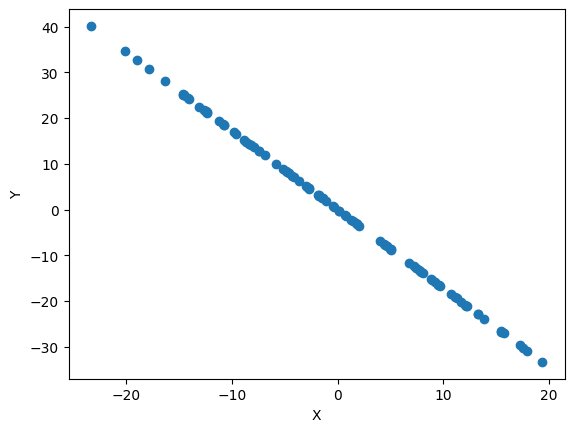

In [8]:
n = 100
p = 1
X = np.random.normal(0, 10, (n, p))
theta = np.random.normal(0, 1, (p, ))
Y = X @ theta
plt.scatter(X, Y)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [9]:
X_train, X_test = X[:80], X[80:]
Y_train, Y_test = Y[:80], Y[80:]

In [10]:
# linear regression
simple_sm = sm.OLS(Y_train, sm.add_constant(X_train)).fit()
train_SSE1 = np.sum(simple_sm.resid**2)
test_SSE1 = np.sum((Y_test - simple_sm.predict(sm.add_constant(X_test)))**2)
simple_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.012e+33
Date:                Sat, 08 Mar 2025   Prob (F-statistic):               0.00
Time:                        09:25:01   Log-Likelihood:                 2522.5
No. Observations:                  80   AIC:                            -5041.
Df Residuals:                      78   BIC:                            -5036.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.11e-15   5.56e-16     -1.995      0.050   -2.22e-15   -2.49e-18
x1            -1.7190    5.4e-17  -3.18e+16      0.000      -1.719      -1.719
==============================================================================
Omnibus:                        1.778   Durbin-Watson:                   1.660
Prob(Omnibus):                  0.411   Jarque-Bera (JB):                1.230
Skew:                          -0.283   Prob(JB):                        0.541
Kurtosis:                       3.219   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
poly_X = np.hstack((X, X**2, X**3))
poly_X_train, poly_X_test = poly_X[:80], poly_X[80:]
poly_sm = sm.OLS(Y_train, sm.add_constant(poly_X_train)).fit()
train_SSE2 = np.sum(poly_sm.resid**2)
test_SSE2 = np.sum((Y_test - poly_sm.predict(sm.add_constant(poly_X_test)))**2)
poly_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.371e+28
Date:                Sat, 08 Mar 2025   Prob (F-statistic):               0.00
Time:                        09:25:01   Log-Likelihood:                 2119.1
No. Observations:                  80   AIC:                            -4230.
Df Residuals:                      76   BIC:                            -4221.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.245e-14   1.19e-13     -0.356      0.723    -2.8e-13    1.95e-13
x1            -1.7190   1.73e-14  -9.92e+13      0.000      -1.719      -1.719
x2          1.171e-15   7.95e-16      1.473      0.145   -4.12e-16    2.75e-15
x3           3.86e-17   6.68e-17      0.578      0.565   -9.45e-17    1.72e-16
==============================================================================
Omnibus:                        9.281   Durbin-Watson:                   1.644
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                5.633
Skew:                          -0.482   Prob(JB):                       0.0598
Kurtosis:                       2.129   Cond. No.                     3.77e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
print(f"Simple: Train SSE: {train_SSE1:.2f}, Test SSE: {test_SSE1:.2f}")
print(f"Polynomial: Train SSE: {train_SSE2:.2f}, Test SSE: {test_SSE2:.2f}")

Simple: Train SSE: 0.00, Test SSE: 0.00
Polynomial: Train SSE: 0.00, Test SSE: 0.00


From the simulation results above, I find that the results about training SSE and testing SSE matches our previous analysis.

### Problem 3

#### 3a

In [13]:
data = pd.read_csv('data/HW3-3.txt', header=0, sep='\s+')
data.head()

,Y,X1,X2,X3
0,132.0,0.71,38.0,71.0
1,53.0,1.48,78.0,69.0
2,50.0,2.21,69.0,85.0
3,82.0,1.43,70.0,100.0
4,110.0,0.68,45.0,59.0


In [14]:
Y = data["Y"]
X = data[["X1", "X2", "X3"]]
X.shape, Y.shape

((33, 3), (33,))

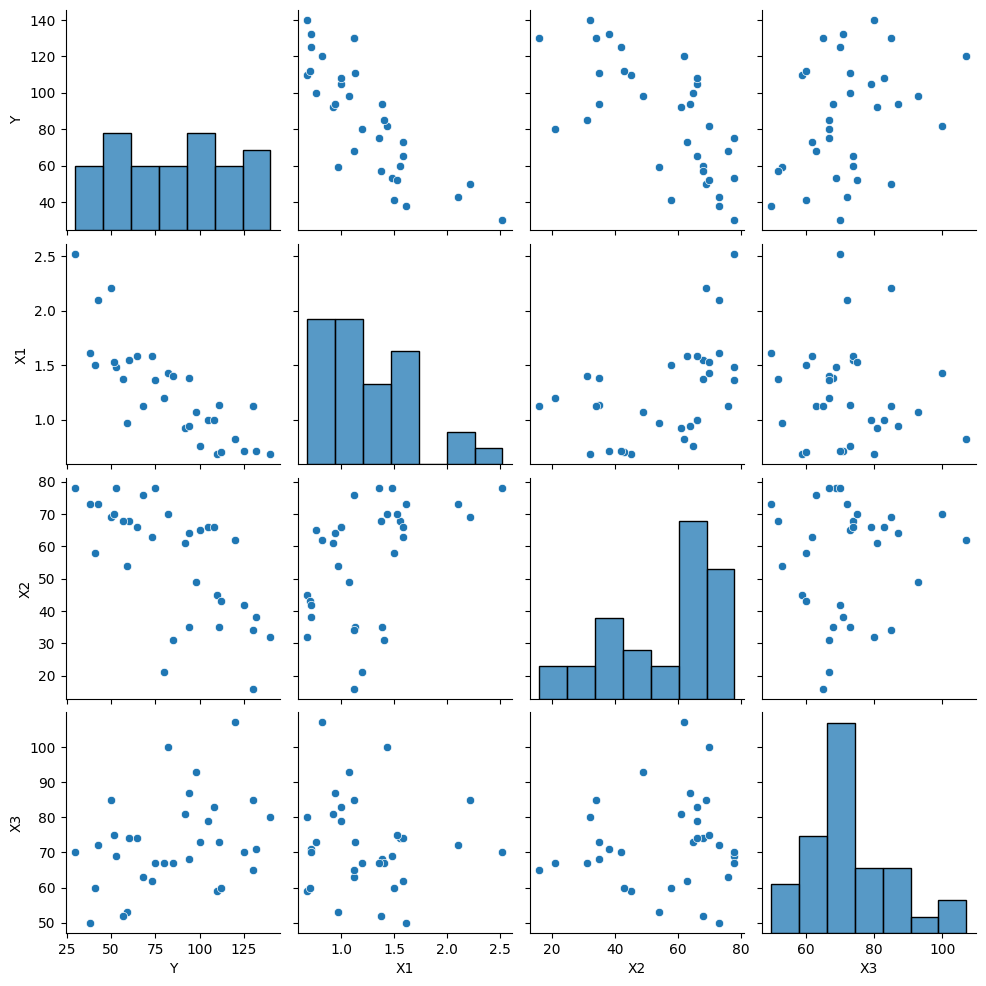

In [15]:
sns.pairplot(data)
plt.show()

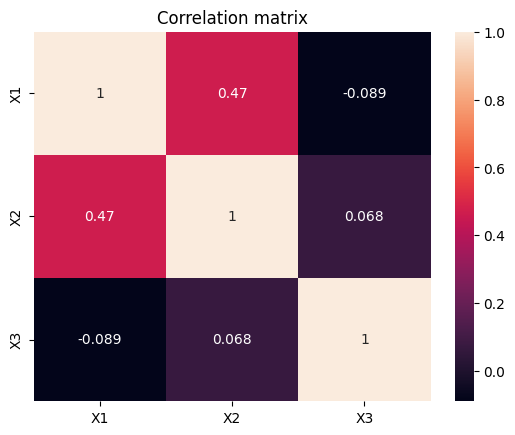

In [16]:
sns.heatmap(X.corr(), annot=True)
plt.title("Correlation matrix")
plt.show()

Each predictor variable has rough linear relationship with Y given the scatterplot matrix.

There is no serious multicollinearity problem given all absolute correlation is less than 0.5.

#### 3b

In [17]:
# 3b
model1 = sm.OLS(Y, sm.add_constant(X)).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     56.92
Date:                Sat, 08 Mar 2025   Prob (F-statistic):           2.88e-12
Time:                        09:25:02   Log-Likelihood:                -127.93
No. Observations:                  33   AIC:                             263.9
Df Residuals:                      29   BIC:                             269.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        120.0473     14.774      8.126      0.000      89.832     150.263
X1           -39.9393      5.600     -7.132      0.000     -51.393     -28.486
X2            -0.7368      0.141     -5.211      0.000      -1.026      -0.448
X3             0.7764      0.172      4.517      0.000       0.425       1.128
==============================================================================
Omnibus:                        2.889   Durbin-Watson:                   2.349
Prob(Omnibus):                  0.236   Jarque-Bera (JB):                2.452
Skew:                          -0.658   Prob(JB):                        0.293
Kurtosis:                       2.768   Cond. No.                         639.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The adjusted $R^2$ is 0.84.

#### 3c

In [18]:
# 3c: F-test
print(f"F-test pvalue: {model1.f_pvalue}")
# model1 = sm.OLS(Y, sm.add_constant(X)).fit()
# sse = np.sum(model1.resid**2)
# sst = np.sum((Y - Y.mean())**2)
# n, p = X.shape
# F = ((sst - sse) / p) / (sse / (n - p - 1))
# alpha = 0.01
# F_crit = st.f.ppf(1 - alpha, p, n - p - 1)
# pval = 1 - st.f.cdf(F, p, n - p - 1)
# print(f"F-statistic: {F:.2f}, p-value: {pval}")

F-test pvalue: 2.884882050444578e-12


With the F-test, the p-value is less that $\alpha=0.01$, so we could reject the null hypothesis that every coefficient equals to 0 with 99% confidence. It means at least one predictor significant in 99% confidence.

#### 3d

In [19]:
# 3d: CI for coefficients
ci = model1.conf_int(alpha=0.01)
ci.columns = ["Lower", "Upper"]
ci

,Lower,Upper
const,79.325251,160.769314
X1,-55.374961,-24.503693
X2,-1.126504,-0.347031
X3,0.302638,1.250200


Based on the confidence intervals, all the predictors (X1, X2, and X3) are statistically significant at the 0.01 significance level (alpha = 0.01). This is because none of their confidence intervals include zero.

#### 3e

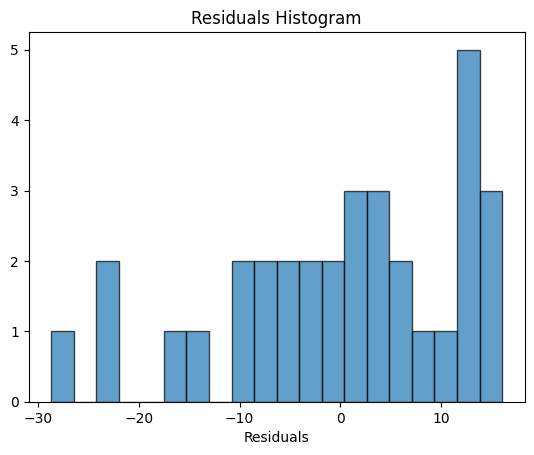

In [20]:
# 3e: residual analysis
residuals = model1.resid
plt.hist(residuals, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel("Residuals")
plt.title("Residuals Histogram")
plt.show()

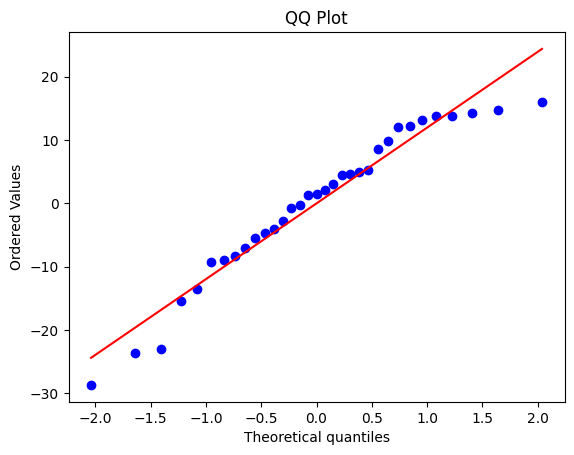

In [21]:
# 3e: QQ plot
st.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot")
plt.show()

Both residual histogram and QQ plot indicate that the assumption about normal distribution is roughly supported. Because histogram is approximately symmetrix at x=0 and points in QQ plot follow the red line.

#### 3f

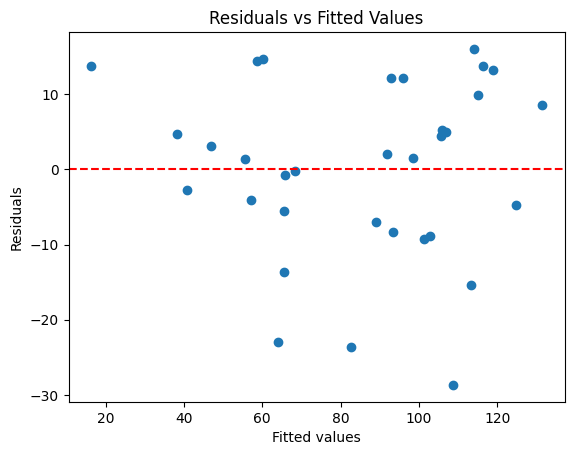

In [22]:
# 3f: residual vs fitted plot
plt.scatter(model1.fittedvalues, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

The residuals appear to be randomly scattered around the horizontal line at zero (the red dashed line), so the linearity assumption is reasonably met. 

#### 3g

In [23]:
# 3g: Breusch-Pagan test
bp_test = het_breuschpagan(model1.resid, model1.model.exog)
print(f"BP test: F-statistic: {bp_test[2]:.2f}, p-value: {bp_test[1]:.6f}")

BP test: F-statistic: 1.77, p-value: 0.163630


We cannot reject the null hypothesis that the variance of error terms are same in 99% confidence given p-value > 0.01. So the homoscedasticity assumption is supported. 

#### 3h

In [24]:
# 3h
data['X1^2'] = data['X1']**2
data['X2^2'] = data['X2']**2
data['X3^2'] = data['X3']**2
data['X1*X2'] = data['X1'] * data['X2']
data['X1*X3'] = data['X1'] * data['X3']
data['X2*X3'] = data['X2'] * data['X3']
X_poly = data[["X1", "X2", "X3", "X1^2", "X2^2", "X3^2", "X1*X2", "X1*X3", "X2*X3"]]
X_poly.shape

(33, 9)

In [25]:
# Define function to compute BIC and adjusted R^2
def evaluate_model(X, y):
    X = sm.add_constant(X)  # Add intercept
    model = sm.OLS(y, X).fit()
    bic = model.bic
    adj_r2 = model.rsquared_adj
    return bic, adj_r2, model

# Find all subsets of predictors
predictor_names = X_poly.columns.tolist()
subset_scores_bic = []
subset_scores_adj_r2 = []

for k in range(1, len(predictor_names) + 1):
    for subset in itertools.combinations(predictor_names, k):
        X_subset = data[list(subset)]
        bic, adj_r2, model = evaluate_model(X_subset, Y)
        # print(subset, X_subset.shape, model.bic, model.rsquared_adj)
        subset_scores_bic.append((subset, bic))
        subset_scores_adj_r2.append((subset, adj_r2))

In [26]:
# Get the three best models according to BIC
best_bic_models = sorted(subset_scores_bic, key=lambda x: x[1])[0]
print(f"Best model based on BIC variables: {best_bic_models[0]}\nBest BIC: {best_bic_models[1]: .2f}")

Best model based on BIC variables: ('X1', 'X2', 'X3', 'X1*X2')
Best BIC:  267.37


In [27]:
# Get the three best models according to Adjusted R^2
best_adj_r2_models = sorted(subset_scores_adj_r2, key=lambda x: x[1], reverse=True)[0]
print(f"Best model based on adjusted R^2: {best_adj_r2_models[0]}\nBest Adj R^2: {best_adj_r2_models[1]: .2f}")

Best model based on adjusted R^2: ('X1', 'X2', 'X3', 'X3^2', 'X1*X2')
Best Adj R^2:  0.87


The results are different when using different metric to select model.

### Problem 4

#### 4a
The log-likelihood function is
$$
\ell(\beta_0,\beta_1, \sigma^2) = -\frac{1}{2\sigma^2}\sum_{i=1}^n (y_i-\beta_1x_i - \beta_0)^2 - \frac{n}{2}\log(2\pi\sigma^2)
$$
Use MLE to estimate $\sigma^2$:
$$
\frac{\partial \ell}{\partial \sigma^2} = \frac{1}{2\sigma^4}\sum_{i=1}^n (y_i-\beta_1x_i - \beta_0)^2 - \frac{n}{2\sigma^2} = 0
$$

$$
H_0: \hat{\sigma}^2_0 = \frac{\sum_{i=1}^n (y_i- \beta_0)^2}{n} = \frac{\sum_{i=1}^n (y_i-\overline{y} + \beta_1x_i)^2}{n} = \frac{\sum_{i=1}^n (y_i - \overline{y})^2}{n} = \frac{SST}{n}
$$

$$
H_a:\hat{\sigma}^2_a = \frac{\sum_{i=1}^n (y_i- \beta_0- \beta_1x_i)^2}{n} = \frac{SSE}{n}
$$

So the likelihood ratio is



#### 4b

With LRT, we have rejection region: 
$$
\begin{split}
\{x_1,\cdots, x_n: \Lambda < k\} &\Rightarrow\Bigg(\frac{SSE}{SST}\Bigg)^{\frac{n}{2}}  < k \\
&\Rightarrow \frac{SSE}{SST} < k^{-\frac{n}{2}} \Rightarrow \frac{SST - SSR}{SST} = 1 - \frac{SSR}{SST} < k^{-\frac{n}{2}} \\
&\Rightarrow \frac{SSR}{SST} > 1 - k^{-\frac{n}{2}} \Rightarrow \frac{SSR}{SST/(n-2)} > (n-2)(1 - k^{-\frac{n}{2}})
\end{split}
$$
which is equivalent to $\displaystyle F = \frac{SSR}{SST/(n-2)} > c$


#### 4c

In [28]:
n = 120
alpha = 0.01
p = 1

SSE = 45.818
SSR = 3.58
F = (SSR / p) / (SSE / (n - p - 1))
F_crit = st.f.ppf(1 - alpha, p, n - p - 1)
pval = 1 - st.f.cdf(F, p, n - p - 1)
print(f"F-statistic: {F:.2f}, Critical value: {F_crit:.2f}, p-value: {pval:.6f}")

F-statistic: 9.22, Critical value: 6.85, p-value: 0.002947


#### 4d

In [29]:
SST = SSE + SSR
LR = (SSE / SST) ** (n / 2)
G_square = -2 * np.log(LR)
G_square_crit = st.chi2.ppf(1 - alpha, p)
pval = 1 - st.chi2.cdf(G_square, p)
print(f"G-square: {G_square:.2f}, Critical value: {G_square_crit:.2f}, p-value: {pval:.6f}")

G-square: 9.03, Critical value: 6.63, p-value: 0.002659


The asymptotic approximation has similar p-value with F-test.